In [26]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

from recycle_cnn import CNN
from recycle_resnet import ResNet, BasicBlock


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 0.0005
epochs = 15
batch_size = 32

In [28]:
trans = transforms.ToTensor()
train_set = torchvision.datasets.ImageFolder('data/train',transform=trans)

aug_trans1 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
aug_trans2 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])
aug_train_set1 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans1)
aug_train_set2 = torchvision.datasets.ImageFolder('data/train', transform=aug_trans2)

train_all_set = torch.utils.data.ConcatDataset([train_set, aug_train_set1, aug_train_set2])
train_loader = DataLoader(train_all_set, batch_size=batch_size, shuffle=True)


In [29]:
valid_set = torchvision.datasets.ImageFolder('data/valid',transform=trans)
valid_loader = DataLoader(valid_set)

In [30]:
model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

In [31]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

total_batch = len(train_loader)


In [32]:
print(model)

CNN(
  (act): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [33]:
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [34]:
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [35]:
def eval_one_epoch(data_loader):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        return loss, accuracy, correct_pred, total_pred

In [36]:
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = [] 
valid_class_acc_hist = {classname: [] for classname in classes}
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss_hist[-1]}, accuracy: {train_acc_hist[-1]}\n"+
        f"Valid loss: {valid_loss_hist[-1]}, accuracy: {valid_acc_hist[-1]}")
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        valid_class_acc_hist[classname].append(accuracy)
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Epoch: 0
Train Loss: 2.5267837047576904, accuracy: 41.87405776977539
Valid loss: 1.2351734638214111, accuracy: 55.79268264770508
Accuracy for class: cardboard is 80.4 %
Accuracy for class: glass is 18.5 %
Accuracy for class: metal is 39.3 %
Accuracy for class: paper is 75.9 %
Accuracy for class: plastic is 72.1 %
Accuracy for class: trash is 29.4 %
Epoch: 1
Train Loss: 1.4043346643447876, accuracy: 52.7714958190918
Valid loss: 1.4444680213928223, accuracy: 52.439022064208984
Accuracy for class: cardboard is 41.3 %
Accuracy for class: glass is 26.2 %
Accuracy for class: metal is 32.1 %
Accuracy for class: paper is 89.2 %
Accuracy for class: plastic is 54.1 %
Accuracy for class: trash is 64.7 %
Epoch: 2
Train Loss: 1.1308189630508423, accuracy: 59.74736022949219
Valid loss: 1.3639541864395142, accuracy: 50.91463088989258
Accuracy for class: cardboard is 76.1 %
Accuracy for class: glass is 47.7 %
Accuracy for class: metal is 28.6 %
Accuracy for class: paper is 54.2 %
Accuracy for class: p

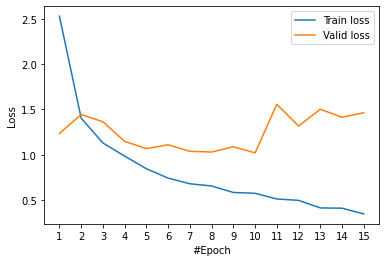

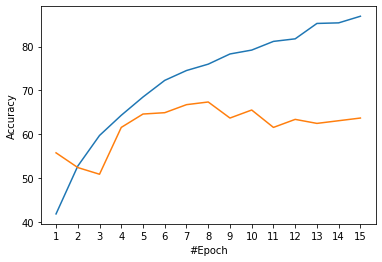

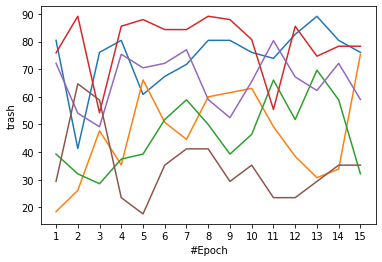

In [37]:
epochs = list(range(1, epochs + 1))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.show()

for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s accuracy' % classname)
    plt.xlabel("#Epoch")
    plt.ylabel(classname)
    plt.xticks(epochs)
plt.show()



In [38]:
torch.save(model, 'model.pt')